In [1]:
from typing import TypedDict, Optional, List, Callable, Dict, Any, Literal
from typing_extensions import Annotated
import os
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage
from langchain_groq import ChatGroq
from langgraph.checkpoint.memory import MemorySaver
from youtube_transcript_api import YouTubeTranscriptApi
from langgraph.graph import StateGraph, add_messages
from dotenv import load_dotenv
from IPython.display import Image, display
from langgraph.graph import START, END

In [2]:
load_dotenv()
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

In [3]:
class BlogGenState(TypedDict):
    yt_url: Optional[str]
    transcript: Optional[str]
    blog_title: Optional[str]
    blog_content: Optional[str]
    regenerate_status: Optional[str]
    feedback : Optional[str]
    message: Annotated[list[AnyMessage], add_messages]
    next_state: Optional[str]

In [4]:
class Agents:
    def __init__(self):
        self.llm = ChatGroq(model="qwen-2.5-32b")
    def generate_blog(self, state: BlogGenState) -> BlogGenState:
        """
        Generates a title and content for the blog based on the transcript.
        
        Args:
            state: The current state of the workflow
            
        Returns:
            Updated state with blog title and content
        """
        transcript = state.get("transcript")
        if transcript is None:
            video_id = state["yt_url"].split("v=")[-1].split("&")[0]
            transcript_list = YouTubeTranscriptApi.get_transcript(video_id)
            full_transcript = " ".join([entry['text'] for entry in transcript_list])
            state["transcript"] = full_transcript
        regen_status = state.get("regenerate_status")
        if regen_status == "yes":
            content_regenerate_prompt = [
                SystemMessage(content=f"The user has chosen to regenerate the blog content. Please provide new content for the blog post based on the transcript and the given feedback: \n {state['feedback']}\n. PREVIOUS INSTRUCTIONS: You are an expert in generating content for BLOG posts based on the transcripts of YouTube videos. IMPORTANT: YOU SIMPLY ONLY CREATE CONTENT FOR THE BLOG. THE TITLE IS ALREADY PROVIDED. Output format: Simply output the content in markdown format with appropriate headings, paragraphs, and formatting."),
                HumanMessage(content=f"Generate blog content for the title '{state['blog_title']}' based on the following transcript: {state['transcript']}")
            ]
            regenerated_content = self.llm.invoke(content_regenerate_prompt).content.strip()

            return {
                "blog_content": regenerated_content,
                "message": state["message"] + [
                    SystemMessage(content=f"Blog title and content regenerated on the users request.")
                ]
            }

        title_prompt = [
            SystemMessage(content="You are an expert in generating titles for BLOG posts based on the transcripts of YouTube videos. IMPORTANT: YOU SIMPLY ONLY CREATE TITLES FOR THE BLOG. NO EXPLANATION IS REQUIRED."),
            HumanMessage(content=f"Generate a good blog title for a video with the following transcript: {state['transcript']}")
        ]
        blog_title = self.llm.invoke(title_prompt).content.strip()

        content_prompt = [
            SystemMessage(content="""You are an expert in generating content for BLOG posts based on the transcripts of YouTube videos. 
            IMPORTANT: YOU SIMPLY ONLY CREATE CONTENT FOR THE BLOG. THE TITLE IS ALREADY PROVIDED. 
            Output format: Simply output the content in markdown format with appropriate headings, paragraphs, and formatting."""),
            HumanMessage(content=f"Generate blog content for the title '{blog_title}' based on the following transcript: {state['transcript']}")
        ]
        blog_content = self.llm.invoke(content_prompt).content.strip()

        return {
            "blog_title": blog_title,
            "blog_content": blog_content,
            "message": state["message"] + [
                SystemMessage(content="Transcript fetched successfully."),
                SystemMessage(content=f"Blog title generated: {blog_title}"),
                SystemMessage(content="Blog content generated successfully.")
            ],
            "next_state": "human_feedback"
        }
    def human_feedback(self, state: BlogGenState) -> BlogGenState:
        """Just an empty to update the feedback param"""
        return state

In [5]:
class BlogGenGraph:
    def __init__(self):
        self.agents = Agents()
    def regenerate_condition_or_not(self, state: BlogGenState) -> Literal["regenerate","end"]:
        if state["regenerate_status"] == "yes":
            return "regenerate"
        else:    
            return "end" 
    def create_graph(self):
        graph_builder = StateGraph(BlogGenState)
        graph_builder.add_node("generate_blog_with_title",self.agents.generate_blog)
        graph_builder.add_node("human_feedback",self.agents.human_feedback)
        graph_builder.add_edge("generate_blog_with_title","human_feedback")
        graph_builder.add_conditional_edges("human_feedback",self.regenerate_condition_or_not, {"regenerate": "generate_blog_with_title", "end": END})

        graph_builder.set_entry_point("generate_blog_with_title")

        memory = MemorySaver()
        graph = graph_builder.compile(checkpointer=memory, interrupt_before=["human_feedback"])
        return graph

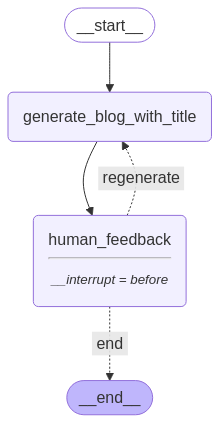

In [6]:
graph = BlogGenGraph().create_graph()
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [7]:
youtubelink = "https://www.youtube.com/watch?v=SmyPTnlqhlk"
thread = {"configurable": {"thread_id": "1"}}

In [8]:
for event in graph.stream({"yt_url": youtubelink},thread, stream_mode="values"):
    content = event.get("blog_content")
    print(content)

None
# 10 Mind-Boggling Algorithms That Changed the World: From Quantum Computing to Video Game Maps

## Introduction

Have you ever wondered how complex tasks like generating 3D models or creating random yet cohesive game maps are accomplished? These marvels are brought to life by algorithms – intricate sets of instructions that solve specific problems. In this blog post, we'll delve into 10 fascinating algorithms that have changed the world in ways you might never have imagined.

## Wave Function Collapse: The Quantum Map Generator

One of the most intriguing algorithms is wave function collapse. Inspired by the wave-particle duality in quantum mechanics, this algorithm is used to generate infinite, coherent maps for video games. The map starts in a "superposition" of all possible tile configurations. As the algorithm progresses, it "collapses" the map into a specific configuration, akin to how quantum particles behave when observed.

## Diffusion: The Magic Behind AI-Generated Image

In [9]:
graph.get_state(thread).next

('human_feedback',)

In [10]:
human_feedback = "Add a more funny tone to the blog post."

In [11]:
graph.update_state(thread, {"regenerate_status": "yes", "next_state":"regenerate", "feedback":human_feedback}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0058e7-e976-68b3-8002-a08bd3763337'}}

In [12]:
for event in graph.stream(None,thread, stream_mode="values"):
    print(event.get("blog_content"))

# 10 Mind-Boggling Algorithms That Changed the World: From Quantum Computing to Video Game Maps

## Introduction

Have you ever wondered how complex tasks like generating 3D models or creating random yet cohesive game maps are accomplished? These marvels are brought to life by algorithms – intricate sets of instructions that solve specific problems. In this blog post, we'll delve into 10 fascinating algorithms that have changed the world in ways you might never have imagined.

## Wave Function Collapse: The Quantum Map Generator

One of the most intriguing algorithms is wave function collapse. Inspired by the wave-particle duality in quantum mechanics, this algorithm is used to generate infinite, coherent maps for video games. The map starts in a "superposition" of all possible tile configurations. As the algorithm progresses, it "collapses" the map into a specific configuration, akin to how quantum particles behave when observed.

## Diffusion: The Magic Behind AI-Generated Images

Di

In [13]:
graph.get_state(thread).next

('human_feedback',)

In [14]:
graph.update_state(thread, {"regenerate_status": "no", "next_state":"end", "waiting_for_input": "no"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0058e9-59a8-69f5-8004-90fd6cb7ce3b'}}

In [15]:
for event in graph.stream(None,thread, stream_mode="values"):
    print(event["blog_content"])

# 10 Mind-Boggling Algorithms That Changed the World: From Quantum Computing to Video Game Maps

## Introduction

Have you ever woken up in the middle of the night in a panic, wondering how to extract a polygonal mesh of an ISO surface from a three-dimensional discrete scalar field? No? Well, I didn't think so. But back in '87, two programmers at General Electric did. They created and patented the marching cubes algorithm, an algorithm that has likely saved countless lives by allowing doctors to visualize data from CT and MRI scans. So, when you're lying on a table getting scanned, you can thank those two for making sure your data looks like a masterpiece.

When you instruct a machine to solve a problem with code, you're creating an algorithm. It's like giving your computer a recipe for rearranging ones and zeros so that it can make animals talk and vacuums walk. Most algorithms belong in the dumpster, but some are fast, some are beautiful, and some are so weird they're indistinguishab

In [16]:
graph.get_state(thread)

StateSnapshot(values={'yt_url': 'https://www.youtube.com/watch?v=SmyPTnlqhlk', 'blog_title': '10 Mind-Boggling Algorithms That Changed the World: From Quantum Computing to Video Game Maps', 'blog_content': '# 10 Mind-Boggling Algorithms That Changed the World: From Quantum Computing to Video Game Maps\n\n## Introduction\n\nHave you ever woken up in the middle of the night in a panic, wondering how to extract a polygonal mesh of an ISO surface from a three-dimensional discrete scalar field? No? Well, I didn\'t think so. But back in \'87, two programmers at General Electric did. They created and patented the marching cubes algorithm, an algorithm that has likely saved countless lives by allowing doctors to visualize data from CT and MRI scans. So, when you\'re lying on a table getting scanned, you can thank those two for making sure your data looks like a masterpiece.\n\nWhen you instruct a machine to solve a problem with code, you\'re creating an algorithm. It\'s like giving your comput